# 여러분의 MBTI는?

In [21]:
# 필요 패키지 호출
!pip install psycopg2-binary
!pip install psycopg2
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
import re
import pyautogui
import random
import psycopg2
import pandas as pd
import urllib.request
import json

### DB 불러오기

In [2]:
# DB 생성
conn_str = "host=localhost dbname=project user=postgres password=admin port=5432"

try:
    conn = psycopg2.connect(conn_str)
    print("=== 접속 성공 =====")
# except:
#   print("접속오류 !!")

except psycopg2.DatabaseError as db_err:
    print("접속오류 !!")
    print(db_err)
    
cur = conn.cursor() # cursor 인스턴스 : 데이터 조작용 생성


=== 접속 성공 =====


### instagram 크롤링을 위한 함수 정의 및 준비

In [ ]:
## 리스트 
MBTI = {"#ISTJ":0,"#ISTP":0,"#ISFJ":0,"#ISFP":0,"#INTJ":0,"#INTP":0,"#INFJ":0,"#INFP":0,
        "#ESTJ":0,"#ESTP":0,"#ESFJ":0,"#ESFP":0,"#ENTJ":0,"#ENTP":0,"#ENFJ":0,"#ENFP":0}

mbti = list(MBTI.keys())

Mbti = []
for i in range(mbti):
        Mbti.append(i.replace('#',''))

In [ ]:
# 함수 정의 : 검색어 조건에 따른 url 생성
def insta_searching(word):
    url = f"https://www.instagram.com/explore/tags/{word}"
    return url

In [ ]:
# 함수정의 : 열린 페이지에서 첫번째 게시물 클릭 + sleep 메소드 통하여 시차 두기
def select_first(driver):
    first = driver.find_elements_by_css_selector('div._9AhH0')[0]
    first.click()
    time.sleep(random.randint(2,5))

In [ ]:
# 함수 정의 : 본문 내용, 작성일자, 좋아요 수, 해시태그 가져오기
import re
from bs4 import BeautifulSoup

def get_content(driver):
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    # 본문 내용
    try:
        content = soup.select('div.C4VMK > span')[0].text
    except:
        content = " "

    # 해시태그
    tags = re.findall(r'#[^\s#,\\]+', content)

    # 작성일자
    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
    
    # 좋아요
    try:
        like = soup.select('div._7UhW9.xLCgt.qyrsm')[0].text
    except:
        like = 0
    

    return content, tags,date,like

In [ ]:
# 첫 번째 게시물 클릭 후 다음 게시물 클릭
def move_next(driver):
    right = driver.find_element_by_css_selector("div.l8mY4.feth3")
    right.click()
    time.sleep(random.randint(3,5))

### instagram 크롤링 코드
* time.sleep()을 이용하여 페이지 막히는 것 예방

In [ ]:
# 크롤링 시작
"""
driver.get(url)을 통해 검색 페이지 접속하고,
target 변수에 크롤링할 게시글의 수를 바인딩
"""

## ENFP, INFP, INFJ

# 인스타그램 로그인을 위한 계정 정보
username = pyautogui.prompt("인스타 아이디를 입력하세요.")
userpw = pyautogui.prompt("비밀번호를 입력하세요.")
time.sleep(3)

# 크롬 브라우저 열기
driver = webdriver.Chrome(r"C:\chromedriver.exe")
driver.get('https://www.instagram.com')
# loginUrl = 'https://www.instagram.com/accounts/login/'
time.sleep(random.randint(3,5))

# login
driver.find_element_by_name('username').send_keys(username)
driver.find_element_by_name('password').send_keys(userpw)
time.sleep(random.randint(1,2))
driver.find_element_by_css_selector('button.sqdOP.L3NKy.y3zKF').click()
time.sleep(random.randint(3,5))

# 정보 나중에 저장하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.sqdOP.yWX7d.y3zKF').click()
time.sleep(random.randint(3,5))
# 설정 나중에하기 클릭하고 넘어가기
driver.find_element_by_css_selector('button.aOOlW.HoLwm').click()
time.sleep(random.randint(3,5))


# 게시물을 조회할 검색 키워드 입력 요청
word = pyautogui.prompt("검색어를 입력하세요.")
url = insta_searching(word)

# 검색 결과 페이지 열기
driver.get(url)
time.sleep(random.randint(5,8))

# 첫 번째 게시물 클릭
select_first(driver)

# 본격적으로 데이터 수집시작
## 수집할 게시물의 수 (최근 500개)

for n in range(500):
    print(n)
    
    try:
        # 날짜, 내용, 해시태그, 좋아요 수
        content,tags,date,like = get_content(driver)
        move_next(driver)
        
        if n < 9 or word != 'MBTI':
            if word != 'MBTI':
                try:
                    # 각 mbti에 대한 날짜, 내용, 해시태그, 좋아요 수  DB
                    cur.execute(f"INSERT INTO public.{word.lower()} (day, content, tags, insta_like) VALUES (%s,%s,%s,%s);",(date,content,tags,like))
                    conn.commit()

                except:
                    conn.rollback()
                    print("--- DB error")
            else:
                try:
                    # 검색어 'MBTI'의 인기게시물에 대한 날짜, 내용, 해시태그, 좋아요 수  DB
                    cur.execute("INSERT INTO public.popular (day, content, tags) VALUES (%s,%s,%s);",(date,content,tags))
                    conn.commit()
                    
                except:
                    conn.rollback()
                    print("--- DB error")
                
            
        else:
            if tags != []:
                for me in tags:
                    for i in range(0,len(MBTI)):            
                        if mbti[i] == me.upper():
                                MBTI[mbti[i]] += 1
                            
            else:
                for j in range(0,len(MBTI)):
                    m = ''.join(char for char in mbti[j] if  char.isalnum())
                    if m in content.upper():
                        MBTI[mbti[j]] += 1

                            
    except:
        time.sleep(random.randint(1,2))
        move_next(driver)

# mbti별 언급된 수 DB
for no in mbti:
    try:
        cur.execute("INSERT INTO public.count (mbti,n) VALUES (%s,%s);",(no.replace('#',''),MBTI[no]))
        conn.commit()

    except:
        conn.rollback()
        print("--- DB error")

print(f'총 게시물 수 는 (최대1000개만 수집) : {n-8}')

### 인스타 DB를 이용한 시각화 
* 그래프 그리기 함수 정의

In [33]:
# line & bar 그래프
def plot2(x,y,title,kind, xlabel, ylabel):
    import platform
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import seaborn as sns

    # 한글 깨지는 현상 수정
    system_name = platform.system()
    if system_name == 'Windows':
        # Windows 운영체제
        plt.rc('font', family='Malgun Gothic')
    elif system_name == 'Darwin':
        # Mac OS
        plt.rc('font', family='AppleGothic')
    elif system_name == 'Linux':
        # Linux
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
        font_name = fm.FontProperties(fname=path, size=12)
        plt.rc('font', family=font_name)
    else:
        print("Not support")

    # 그래프 그리기
    colors = sns.color_palette("pastel", len(x)) ## 색상 지정
    plt.figure(figsize=(10,5))
    if kind == 'line':
        plt.plot(x,y,label=ylabel,marker='H')
            

    elif kind == 'bar':
        plt.bar(x,y,color=colors,edgecolor='black')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

* MBTI별 언급된 수 (인스타)

In [7]:
# Count DB 데이터 불러오기 (863)
try:
    cur.execute("select * from public.count;") # sql 문장
    conn.commit()
    count = cur.fetchall()
    
except:
    conn.rollback()
    print("--- DB error")

No handles with labels found to put in legend.


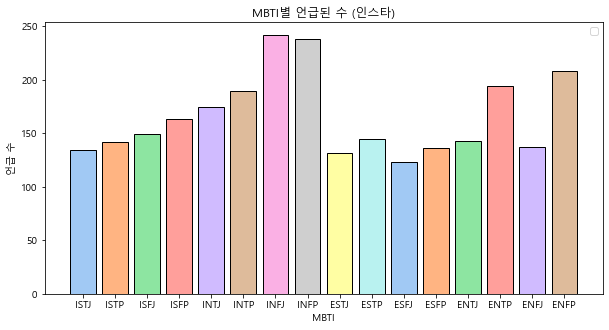

In [27]:
# 그래프 그리기
mbti = []
n = []
for i in range(0,len(count)):
    mbti.append(count[i][0])
    n.append(count[i][1])

plot2(mbti,n,'MBTI별 언급된 수 (인스타)','bar','MBTI','언급 수')

In [14]:
# DB 데이터 조회 불러오기 (INFJ, INFP, ENFP)
top3 = ['infj', 'infp', 'enfp']
idx = 0

top3_df = pd.DataFrame(columns=['mbti','전체게시물', '좋아요 게시물', '1000개이상', '500개이상',  '500개미만'])

for m in top3:
    try:
        cur.execute(f"select * from public.insta_{m};")
        conn.commit()
        mbti_kind = cur.fetchall()
        
        n1,n2,n3 = 0,0,0 # n1 : 1000개이상 n2 : 500개이상 n3 : 나머지
        for i in range(0,len(mbti_kind)):
            # like의 형태가 '좋아요 1,245개'이므로, 1245 형태로 변환 작업 실시 
            if '좋' in mbti_kind[i][3]:
                if int(mbti_kind[i][3][4:-1].replace(',','')) > 999:
                    n1 += 1
                elif int(mbti_kind[i][3][4:-1].replace(',','')) > 499:
                    n2 += 1
                else:
                    n3 += 1
        top3_df.loc[idx] = [m,len(mbti_kind),(n1+n2+n3),n1,n2,n3,]
        idx += 1
          
    except:
        conn.rollback()
        print("--- DB error")

mbti_kind[0][3]

'좋아요 1,245개'

In [36]:
전체대비좋아요 = []
좋아요대비1000 = []
좋아요대비500 = []

# 좋아요 변수 정의 (반올림 작업)
for i in range(0,len(top3_df)):
    a1 = round((top3_df.iloc[i][2]/top3_df.iloc[i][1]*100), 2)
    a2 = round((top3_df.iloc[i][3]/top3_df.iloc[i][1]*100), 2)
    a3 = round(((top3_df.iloc[i][3]+top3_df.iloc[i][4])/top3_df.iloc[i][2]*100), 2)

    전체대비좋아요.append(a1)
    좋아요대비1000.append(a2)
    좋아요대비500.append(a3)

# Dataframe 열 추가
top3_df['전체대비좋아요']=전체대비좋아요
top3_df['좋아요대비1000']=좋아요대비1000
top3_df['좋아요대비500']=좋아요대비500

top3_df

,mbti,전체게시물,좋아요 게시물,1000개이상,500개이상,500개미만,전체대비좋아요,좋아요대비1000,좋아요대비500
0,infj,480,373,37,39,297,77.71,7.71,20.38
1,infp,491,415,43,27,345,84.52,8.76,16.87
2,enfp,495,433,25,29,379,87.47,5.05,12.47


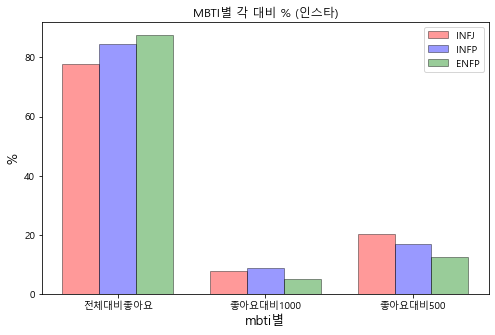

In [39]:
## 그래프 그리기
import matplotlib.pyplot as plt
import numpy as np

# 그림 사이즈, 바 굵기 조정
plt.figure(figsize=(8,5))
bar_width = 0.25

# MBTI가 3개이므로 0, 1, 2 위치를 기준으로 삼음
index = np.arange(3)

# 각 변수별로 3개 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, list(top3_df.loc[0][6:]), bar_width, alpha=0.4, color='red', label='INFJ',edgecolor='black')

b2 = plt.bar(index + bar_width, list(top3_df.loc[1][6:]), bar_width, alpha=0.4, color='blue', label='INFP',edgecolor='black')

b3 = plt.bar(index + 2 * bar_width, list(top3_df.loc[2][6:]), bar_width, alpha=0.4, color='green', label='ENFP',edgecolor='black')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
plt.xticks(np.arange(bar_width, 3 + bar_width, 1), ['전체대비좋아요','좋아요대비1000','좋아요대비500'])

# x축, y축 이름 및 범례 설정
plt.xlabel('mbti별', size = 13)
plt.ylabel('%', size = 13)
plt.title('MBTI별 각 대비 % (인스타)')
plt.legend()

### 도서 API

In [30]:
client_id = "SFBVy_Sps38LXkNxHNoq"
client_secret = "zlixlrNhi3"

query = urllib.parse.quote(input('검색할 단어'))
display = 100
start = 1
end = 1000
idx = 0
sort = 'sim'

df = pd.DataFrame(columns=['Title', 'Link',  'Publisher', 'Isbn', 'Pubdate', 'Description'])

for start_index in range(start, end, display):
    url = "https://openapi.naver.com/v1/search/book?query=" + query + \
        "&display=" + str(display) + \
        "&start=" + str(start_index) + \
        "&sort=" + sort
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    if (rescode == 200):
        response_body = response.read()
        items = json.loads(response_body.decode('utf-8'))["items"]
        remove_tag = re.compile('<.*?>')
        for item_index in range(0, len(items)):
            title = re.sub(remove_tag, '', items[item_index]['title']) # 제목
            link = items[item_index]['link'] # 하이퍼텍스트 link
            image = items[item_index]['image'] # 썸네일 이미지의 URL
            author = items[item_index]['author'] # 저자
            price = items[item_index]['price'] # 정가
            discount = items[item_index]['discount'] # 할인가격
            publisher = items[item_index]['publisher'] # 출판사
            isbn = items[item_index]['isbn'] # 국제표준도서번호(ISBN) 넘버
            description = re.sub(remove_tag, '', items[item_index]['description']) # 검색결과 문서의 내용 요약
            pubdate = items[item_index]['pubdate'] # 출간일

            df.loc[idx] = [title, link, publisher, isbn, pubdate, description]
            idx += 1
    else:
        print("Error Code: " + rescode)

df.loc[0:3]

,Title,Link,Publisher,Isbn,Pubdate,Description
0,흔한남매 흔한 MBTI (믿거나 말거나 나에게 어울리는 직업),http://book.naver.com/bookdb/book_detail.php?b...,대원키즈,1136273794 9791136273796,20210901,흔한남매와 함께 떠나는MBTI 유형별 직업 여행『흔한 MBTI』는 널리 알려진 MB...
1,우리들의 MBTI (나의 성격을 이해하고 더 멋진 내가 되는),http://book.naver.com/bookdb/book_detail.php?b...,다산어린이,1130639401 9791130639406,20210726,MBTI는 성격 유형마다 타고난 강점을 활용하고 단점을 보완하면서 성장할 수 있는 ...
2,나의 MBTI가 궁금하단 마리몽,http://book.naver.com/bookdb/book_detail.php?b...,더모던,1164455354 9791164455355,20211130,"여러분의 MBTI는 무엇입니까?\n\n혈액형 A형은 소심하고, O형은 활발하다고 유..."
3,MBTI의 의미 (MBTI는 과학인가?),http://book.naver.com/bookdb/book_detail.php?b...,하움출판사,1164407112 9791164407118,20201119,&quot;MBTI는 과학적인가?&quot; 이 질문에 대한 나의 대답은 이것이다....


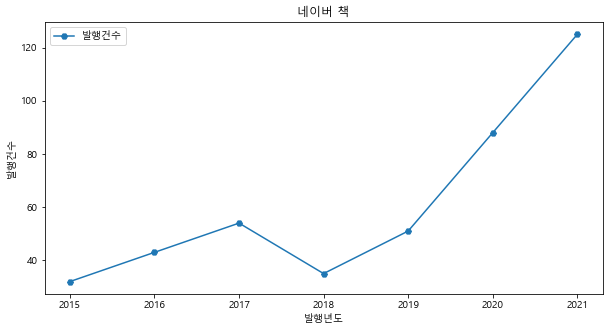

In [34]:
# 데이터 정제
date = {'2015':0,'2016':0,'2017':0,'2018':0,'2019':0,'2020':0,'2021':0}
date_k = list(date.keys())

for i in range(0,len(df)):
    for j in range(0,len(date_k)):
        if date_k[j] in df['Pubdate'][i]:
            date[date_k[j]] += 1

date_v = list(date.values())

# 그래프 그리기
plot2(date_k, date_v, '네이버 책','line','발행년도','발행건수')